In [1]:
import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt
from math import *

Calcula o número de iterações necessárias. N é o número de casos possíveis e M é o número de soluções. 

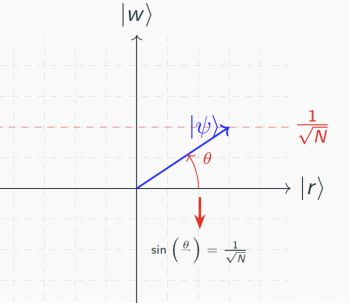

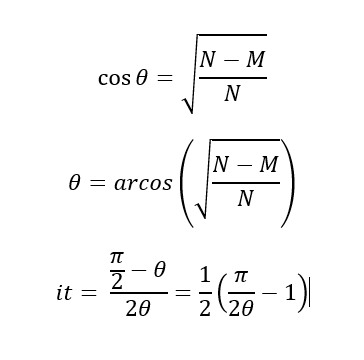

In [2]:
def it(n,m):
    t = ((pi/2)*1/acos(sqrt((n-m)/n))-1)/2
    return t

Consideremos o sudoku binário numa matriz 2x2.
Neste problema, nem as colunas nem as linhas podem conter o mesmo valor duas vezes.

Com este problema, podemos ver como converter um problema de decisão num oráculo do Algoritmo de Grover.

Primeiro, atribuímos cada quadrado do sudoku a uma variável:
![alt text](images/sudoku.jpg)
O nosso circuito do oráculo identifica a solução correta.

Agora, precisamos de uma função clássica que verifique se o estado das nossas variáveis é uma solução válida.
Especificamente, temos as quatro condições.
* $n_1 \neq n_2$ 
* $n_3 \neq n_4$
* $n_1 \neq n_3$
* $n_2 \neq n_4$


In [3]:
# Pares de variáveis que devem ser diferentes (linhas e colunas)
clause_list = [[0, 1],
               [0, 2],
               [1, 3],
               [2, 3]]

Para verificar cada condição, podemos usar uma porta XOR. 

|a|b|output|
|-|-|-|
|0|0|0|
|0|1|1|
|1|0|1|
|1|1|0|

In [4]:
def xor_gate(a, b, target):
    """Aplica XOR entre qubits a e b e guarda o resultado em target"""
    qml.CNOT(wires=[a, target])
    qml.CNOT(wires=[b, target])

c:\Users\pedro\anaconda3\envs\quantica\Lib\site-packages\pennylane\ops\op_math\controlled_ops.py:1171: PennyLaneDeprecationWarning: Specifying control values using a bitstring is deprecated, and will not be supported in future releases, Use a list of booleans or integers instead.
  warnings.warn(
c:\Users\pedro\anaconda3\envs\quantica\Lib\site-packages\pennylane\ops\op_math\controlled_ops.py:1177: UserWarning: The control_wires keyword for MultiControlledX is deprecated, and will be removed soon. Use wires = (*control_wires, target_wire) instead.
  warnings.warn(


(<Figure size 2000x1000 with 1 Axes>, <Axes: >)

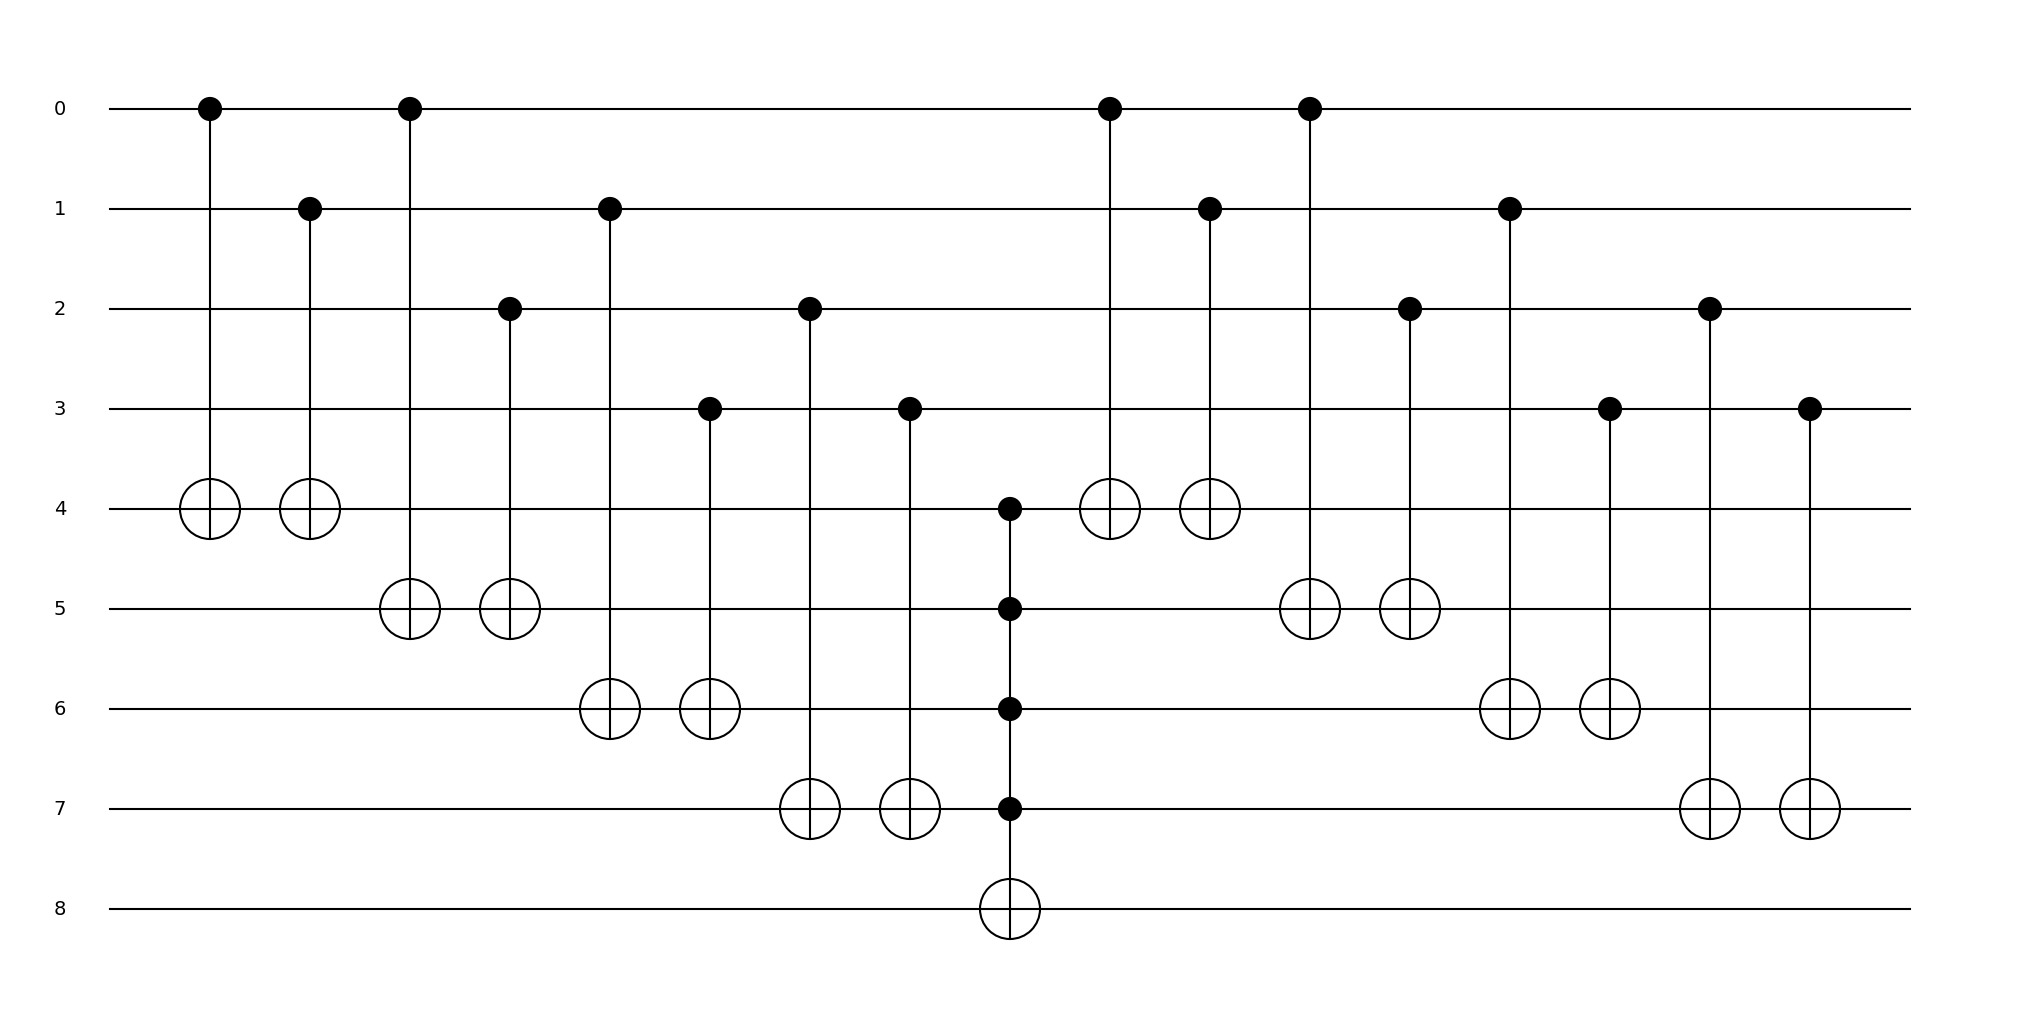

In [5]:
# Número de qubits: 4 variáveis + 4 auxiliares para cláusulas + 1 saída
n_var = 4
n_clause = 4
n_output = 1
n_total = n_var + n_clause + n_output

dev = qml.device("default.qubit", wires=n_total, shots=1024)

# Indices para os grupos de qubits
var_wires = list(range(4))
clause_wires = list(range(4, 8))
output_wire = 8

def sudoku_oracle():
    # Aplicar XOR para cada cláusula
    for i, (a, b) in enumerate(clause_list):
        xor_gate(var_wires[a], var_wires[b], clause_wires[i])
    
    # Aplicar multi-control Toffoli no qubit de saída (marca a solução)
    qml.MultiControlledX(control_wires=clause_wires, wires=output_wire, control_values='1111')
    
    # Desfazer o XOR
    for i, (a, b) in enumerate(clause_list):
        xor_gate(var_wires[a], var_wires[b], clause_wires[i])

qml.drawer.draw_mpl(sudoku_oracle)()

![alt text](images/image.jpg)

O circuito acima identifica os estados que correspondem a soluções a partir de uma mudança de fase. Contudo, a amplitude de todos os estados continua igual, sendo necessário aumentar a amplitude do estado correto e diminuir a dos estados incorretos.
Para isso, é utilizado o diffuser, que corresponde a uma inversão das amplitudes dos estados a partir da sua média.

In [6]:
def diffuser():
    # Inversão sobre a média
    for wire in var_wires:
        qml.Hadamard(wires=wire)
        qml.PauliX(wires=wire)
    
    qml.Hadamard(wires=var_wires[-1])
    
    qml.MultiControlledX(control_wires=var_wires[:-1], wires=var_wires[-1], control_values='111')

    qml.Hadamard(wires=var_wires[-1])
    
    for wire in var_wires:
        qml.PauliX(wires=wire)
        qml.Hadamard(wires=wire)

c:\Users\pedro\anaconda3\envs\quantica\Lib\site-packages\pennylane\ops\op_math\controlled_ops.py:1171: PennyLaneDeprecationWarning: Specifying control values using a bitstring is deprecated, and will not be supported in future releases, Use a list of booleans or integers instead.
  warnings.warn(
c:\Users\pedro\anaconda3\envs\quantica\Lib\site-packages\pennylane\ops\op_math\controlled_ops.py:1177: UserWarning: The control_wires keyword for MultiControlledX is deprecated, and will be removed soon. Use wires = (*control_wires, target_wire) instead.
  warnings.warn(


Contagens: {np.str_('0000'): array(5), np.str_('0001'): array(6), np.str_('0010'): array(8), np.str_('0011'): array(1), np.str_('0100'): array(6), np.str_('0101'): array(4), np.str_('0110'): array(501), np.str_('0111'): array(3), np.str_('1000'): array(5), np.str_('1001'): array(463), np.str_('1010'): array(3), np.str_('1011'): array(5), np.str_('1100'): array(6), np.str_('1101'): array(4), np.str_('1110'): array(3), np.str_('1111'): array(1)}


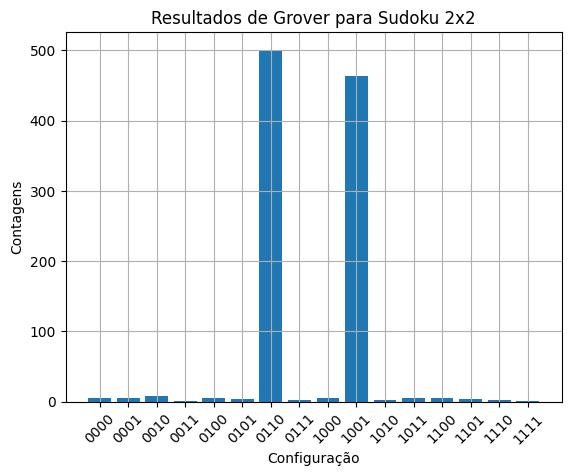

(<Figure size 5200x1000 with 1 Axes>, <Axes: >)

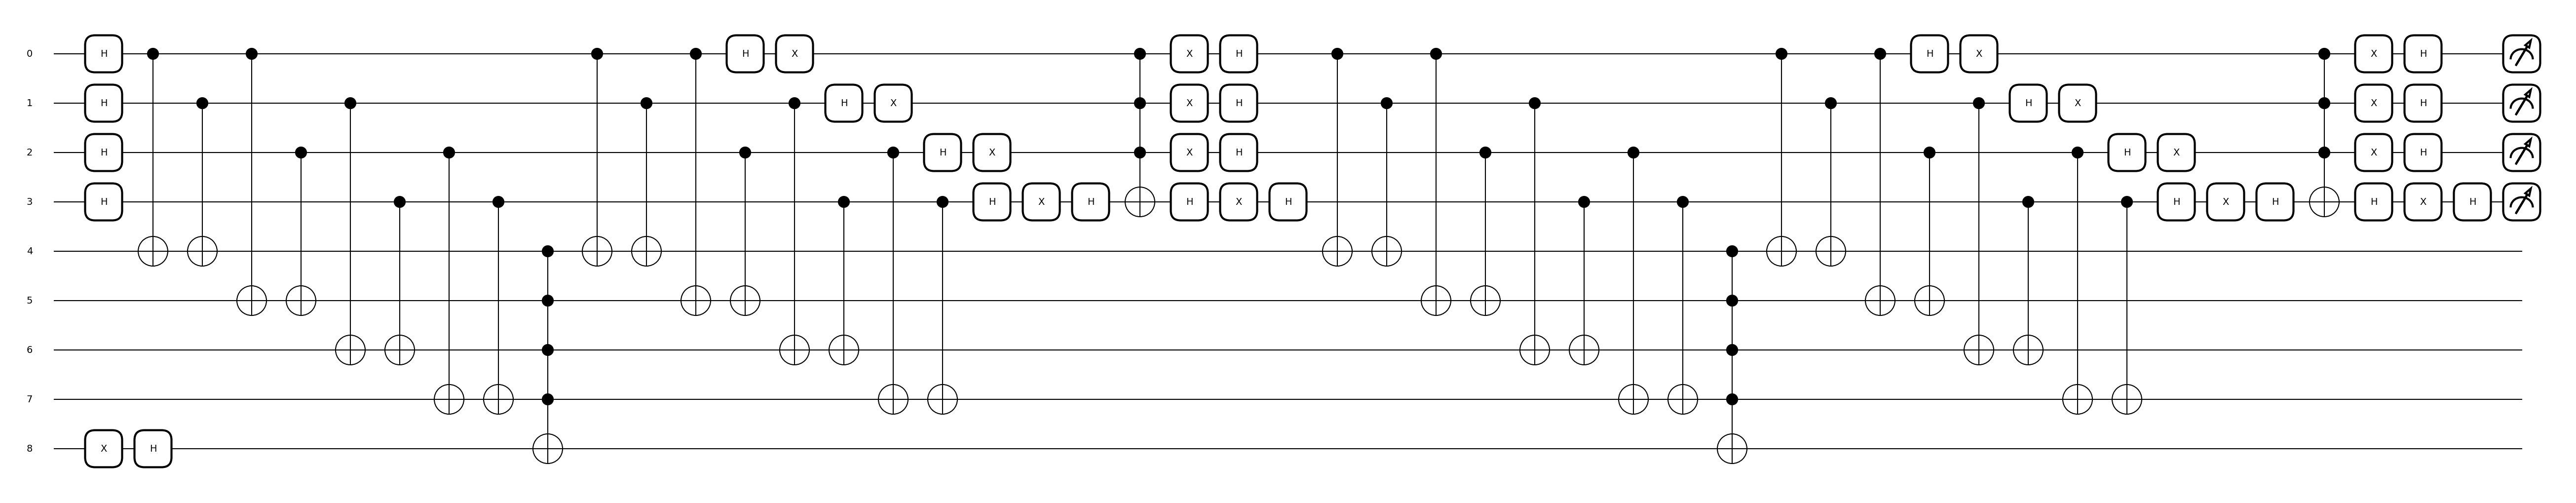

In [7]:
@qml.qnode(dev)
def grover_circuit():
    # Inicializar variáveis em superposição
    for wire in var_wires:
        qml.Hadamard(wires=wire)

    # Inicializar qubit de saída em |->
    qml.PauliX(wires=output_wire)
    qml.Hadamard(wires=output_wire)

    # Iterações de Grover
    for i in range(round(it(16,2))):
        sudoku_oracle()
        diffuser()
    
    

    # Medir apenas os qubits de variáveis
    return qml.counts(wires=var_wires)

# Executar e mostrar os resultados
counts = grover_circuit()
print("Contagens:", counts)

# Gráfico
plt.bar(counts.keys(), counts.values())
plt.title("Resultados de Grover para Sudoku 2x2")
plt.xlabel("Configuração")
plt.ylabel("Contagens")
plt.xticks(rotation=45)
plt.grid(True)
plt.show()
qml.drawer.draw_mpl(grover_circuit)()